# Niveau 2 - Coûts de transaction et volatilité

In [155]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination

project_root = os.path.dirname(os.path.abspath(''))
raw_data = os.path.join(project_root, 'data', 'raw')
processed_data = os.path.join(project_root, 'data', 'processed')
images_path = os.path.join(project_root, 'reports', 'figures')

if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_prep import all_sectors

# Chargement des données
df = pd.read_csv(os.path.join(processed_data, 'daily_returns.csv'), index_col='Date', parse_dates=True)

In [156]:
# Calcul de Mu (Moyenne annualisée)
mu = df.mean() * 252 # 252 : jours de bourses dans une année

# Calcul de Sigma (Matrice de Covariance annualisée)
sigma = df.cov() * 252

print(f"Mu :\n{mu.head()}\nShape : {mu.shape}\n") 
print(f"Sigma :\n{sigma.head(1)}\nShape : {sigma.shape}")

Mu :
GOOGL    0.237949
META     0.272927
DIS      0.064184
NFLX     0.385578
VZ       0.053010
dtype: float64
Shape : (190,)

Sigma :
          GOOGL      META       DIS      NFLX        VZ         T      TMUS  \
GOOGL  0.081055  0.067118  0.032898  0.056137  0.012168  0.016351  0.028229   

          CMCSA      CHTR        EA  ...      WELL      EQIX       NEE  \
GOOGL  0.029109  0.030431  0.031099  ...  0.024942  0.029475  0.019706   

            DUK        SO         D       AEP       EXC       SRE       XEL  
GOOGL  0.012901  0.014868  0.013861  0.012292  0.020565  0.019008  0.014074  

[1 rows x 190 columns]
Shape : (190, 190)


### Fonctions Objectifs  f1, f2 et f3

In [157]:
# Fonction de cout f1 : Maximise le rendement (donc minimise -R)
def f1_rendement(w, mu):
    return -w.T @ mu

# Fonction de cout f2 : Minimise le risque (variance)
def f2_risque(w, sigma):
    return w.T @ sigma @ w

def f3_couts_de_transaction(w, w0, couts):
    return np.sum(np.abs(w - w0)) * couts

# Fonction utilitaire pour récupérer Rendement, Volatilité et Sharpe Ratio d'un poids w
def get_rend_vol_sr(w, mu, sigma):
    rend = w @ mu
    vol = np.sqrt(w.T @ sigma @ w)
    sr = rend / vol
    return rend, vol, sr

### Contraintes de base

In [158]:
num_assets = len(mu)
constraints_base = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1} # Somme(w) = 1
bounds = tuple((0, 1) for _ in range(num_assets)) # 0 <= w <= 1
K_TARGET = 20 # Nombre d'actions dans un portefeuille
transaction_cost = 0.005 # couts de transaction 0.5% de frais

# Initialisation des poids
level1_weights_path = os.path.join(processed_data, 'optimal_weights_level1.csv')

if os.path.exists(level1_weights_path):
    print(f"Chargement des poids initiaux depuis le portefeuille niveau 1 opti")
    w0_df = pd.read_csv(level1_weights_path, index_col=0)
    # Alignement avec les actifs actuels (au cas où l'ordre diffère)
    w0 = w0_df.reindex(mu.index).fillna(0.0).values.flatten()
    print("Poids w0 initialisés avec le Max Sharpe du Niveau 1.")
else:
    print("Fichier Niveau 1 introuvable. Utilisation de l'équipondération.")
    w0 = np.ones(num_assets) / num_assets

Chargement des poids initiaux depuis le portefeuille niveau 1 opti
Poids w0 initialisés avec le Max Sharpe du Niveau 1.


### Optimisation - Recherche du front de Pareto (NGSA II)

Le probleme technique que nous avons maintenant est que $C_{Base}$ (Somme = 1) est facile pour un solveur classique mais $C_{Op}$ (Cardinalité = K) complique fortement le problème car ça transforme le problème en un casse-tête combinatoire et donc en un problème non convexe que scipy.optimize.minimize ne peut pas résoudre directement.

In [159]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, sigma, w_prev, k_card, trans_cost=0.005):
        # Définition du problème pour NSGA-II avec les 3 objectifs (Rendement, Risque, Coûts)
        self.mu = mu
        self.sigma = sigma
        self.w_prev = w_prev
        self.k_card = k_card
        self.trans_cost = trans_cost
        
        # On définit les bornes (0 à 1) et le nombre de variables
        super().__init__(n_var=len(mu), 
                         n_obj=3, # f1, f2, f3
                         n_ieq_constr=0, # Pas de contrainte inéqualité classique car on répare en interne
                         xl=0.0, 
                         xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
       
        # Respecter C_K (Cardinalité) : On identifie les indices des K plus grandes valeurs
        # argsort trie du plus petit au plus grand, on prend les K derniers
        idx_top_k = np.argsort(x)[-self.k_card:]
        
        # On crée un nouveau vecteur w propre avec des 0 partout
        w_clean = np.zeros_like(x)
        
        # On remet les valeurs seulement aux K endroits choisis
        w_clean[idx_top_k] = x[idx_top_k]
        
        # Respecter C_Base (Somme = 1) : On normalise pour que la somme fasse exactement 1.0
        sum_w = np.sum(w_clean)
        if sum_w > 0:
            w_clean = w_clean / sum_w
        else:
            # Cas rare où l'algo propose que des 0, on met 1/K partout
            w_clean[idx_top_k] = 1.0 / self.k_card
            
        # Calcul des 3 Objectifs en utilisant les fonctions définies plus haut
        f1 = f1_rendement(w_clean, self.mu)
        f2 = f2_risque(w_clean, self.sigma)
        f3 = f3_couts_de_transaction(w_clean, self.w_prev, self.trans_cost)
        
        # On renvoie les 3 objectifs à minimiser
        out["F"] = [f1, f2, f3]

In [160]:
problem = PortfolioProblem(
    mu=mu, 
    sigma=sigma, 
    w_prev=w0, 
    k_card=K_TARGET, 
    trans_cost=transaction_cost
)

In [161]:
# Configuration de l'algo
ngsa2 = NSGA2(pop_size=1000) # il va tester 1000 portefeuilles en parallèle à chaque génération

# Critère d'arrêt
termination = get_termination("n_gen", 500) # On lui laisse 500 générations pour s'améliorer (donc 20 000 tests au total)

print("Lancement de NSGA-II")

# Lancement de la simulation
res = minimize(problem,
               ngsa2,
               termination,
               seed=42,
               verbose=True)

print(f"\nTerminé, Solution trouvées : {len(res.X)}")

# res.F contient les valeurs des objectifs (f1, f2, f3) pour les meilleures solutions
# f1 est négatif (-Rendement), f2 est la variance, f3 est le coût

final_returns = -res.F[:, 0]            # On remet le rendement en positif
final_volatility = np.sqrt(res.F[:, 1]) # On passe de Variance à Volatilité (ecart-type = racine carrée de la variance)
final_costs = res.F[:, 2]               # Coûts de transaction
print(f"Nombre de NaNs dans Volatilité : {np.isnan(final_volatility).sum()}")

Lancement de NSGA-II
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |     23 |             - |             -
     2 |     2000 |     41 |  0.1291984820 |         ideal
     3 |     3000 |     57 |  0.1077989981 |         ideal
     4 |     4000 |     44 |  0.2763522993 |         ideal
     5 |     5000 |     31 |  0.1890020225 |         ideal
     6 |     6000 |     37 |  0.0479323202 |         ideal
     7 |     7000 |     50 |  0.0755633872 |         ideal
     8 |     8000 |     75 |  0.1446711374 |         ideal
     9 |     9000 |     68 |  0.0430557346 |         ideal
    10 |    10000 |     66 |  0.0497902906 |         ideal
    11 |    11000 |     71 |  0.0438450812 |         ideal
    12 |    12000 |     95 |  0.0619404075 |         ideal
    13 |    13000 |     88 |  0.0972816044 |         ideal
    14 |    14000 |     88 |  0.0421403225 |         ideal
    15 |    15000 |    100 |  0.0347358300 |         ideal
    16 |    16000 |    125 |  0.054

### Visualisation du front de Pareto

In [162]:
import plotly.graph_objects as go

# On crée la figure 3D
fig = go.Figure(data=[go.Scatter3d(
    x=final_volatility,  # Axe X : Risque
    y=final_costs,       # Axe Y : Coûts
    z=final_returns,     # Axe Z : Rendement
    mode='markers',
    marker=dict(
        size=6,
        color=final_returns, # La couleur dépend du rendement
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Rendement')
    ),
    # Ce qui s'affiche quand on passe la souris
    hovertemplate=(
        "<b>Risque (σ):</b> %{x:.2%}<br>" +
        "<b>Coût (f3):</b> %{y:.4f}<br>" +
        "<b>Rendement:</b> %{z:.2%}<extra></extra>"
    )
)])

# Mise en page propre
fig.update_layout(
    title='Niveau 2 : Front de Pareto 3D Interactif (NSGA-II)',
    scene=dict(
        xaxis_title='Risque (Volatilité σ)',
        yaxis_title='Coûts de Transaction (f3)',
        zaxis_title='Rendement Espéré (E[R])'
    ),
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

# Exportation en HTML pour affichage dans le navigateur
output_path = os.path.join(images_path, "niveau_2_pareto_3d.html")
fig.write_html(output_path)


## Analyse du Portefeuille Sélectionné (Niveau 2)
Nous allons maintenant extraire une solution concrète de ce front de Pareto pour l'analyser.
Comme au Niveau 1, nous choisissons le portefeuille qui maximise le **Ratio de Sharpe** (Rendement / Volatilité) parmi les 100 solutions trouvées, tout en observant ses Coûts de Transaction.

> **Note :** Pour garantir la cohérence avec la contrainte de cardinalité $K$, nous filtrons ici les résultats bruts de l'optimiseur pour ne conserver que les $K$ actifs les plus significatifs (nettoyage du "bruit numérique" des algorithmes génétiques).

In [ ]:
# Identifier le meilleur compromis (Max Sharpe) parmi les solutions du Pareto
sharpe_ratios = final_returns / final_volatility
best_idx = np.argmax(sharpe_ratios)

best_r = final_returns[best_idx]
best_v = final_volatility[best_idx]
best_c = final_costs[best_idx]
best_w = res.X[best_idx]

# L'algorithme génétique peut parfois laisser des poids infimes (1e-5) sur de nombreux actifs.
# Pour l'analyse, on applique strictement la contrainte K_TARGET définie plus haut.
if 'K_TARGET' in globals():
    k_target_val = K_TARGET
    print(f"Application du filtre de cardinalité : Conservation du Top {k_target_val} actifs...")
    
    # Indices des K plus grandes valeurs
    # argsort trie par ordre croissant, on prend les k derniers
    top_k_indices = np.argsort(best_w)[-k_target_val:]
    
    # Création d'un masque pour ne garder que ceux-là
    mask = np.zeros_like(best_w, dtype=bool)
    mask[top_k_indices] = True
    
    # On met à zéro tout ce qui n'est pas dans le Top K
    best_w[~mask] = 0.0
else:
    print("Attention : K_TARGET non défini, pas de filtrage appliqué.")

# Normalisation finale pour affichage (pour que la somme fasse exactement 100% après filtrage)
best_w = best_w / np.sum(best_w)

print(f"Meilleur Portefeuille Niveau 2 (Max Sharpe)")
print(f"Index solution : {best_idx}")
print(f"Rendement      : {best_r:.2%}")
print(f"Volatilité     : {best_v:.2%}")
print(f"Ratio Sharpe   : {best_r/best_v:.2f}")
print(f"Coûts Transac. : {best_c:.4f} (Impact f3)")
# Vérification de la cardinalité réelle après filtrage
real_k = np.sum(best_w > 1e-6)
print(f"Cardinalité    : {real_k} actifs (Cible K={K_TARGET})")

Application du filtre de cardinalité : Conservation du Top 20 actifs...
=== Meilleur Portefeuille Niveau 2 (Max Sharpe) ===
Index solution : 202
Rendement      : 29.42%
Volatilité     : 18.39%
Ratio Sharpe   : 1.60
Coûts Transac. : 0.0042 (Impact f3)
Cardinalité    : 20 actifs (Cible K=20)



Top Allocations :
NVDA    5.34%
TMUS    5.34%
AVGO    5.34%
LLY     5.34%
ANET    5.33%
COST    5.30%
AMD     5.03%
NFLX    4.96%
UNH     4.90%
AMZN    4.90%
DHR     4.90%
AZO     4.88%
KR      4.88%
CHD     4.87%
ORLY    4.84%
TSLA    4.81%
WMT     4.79%
NOC     4.77%
ABBV    4.76%
MCD     4.74%
dtype: object


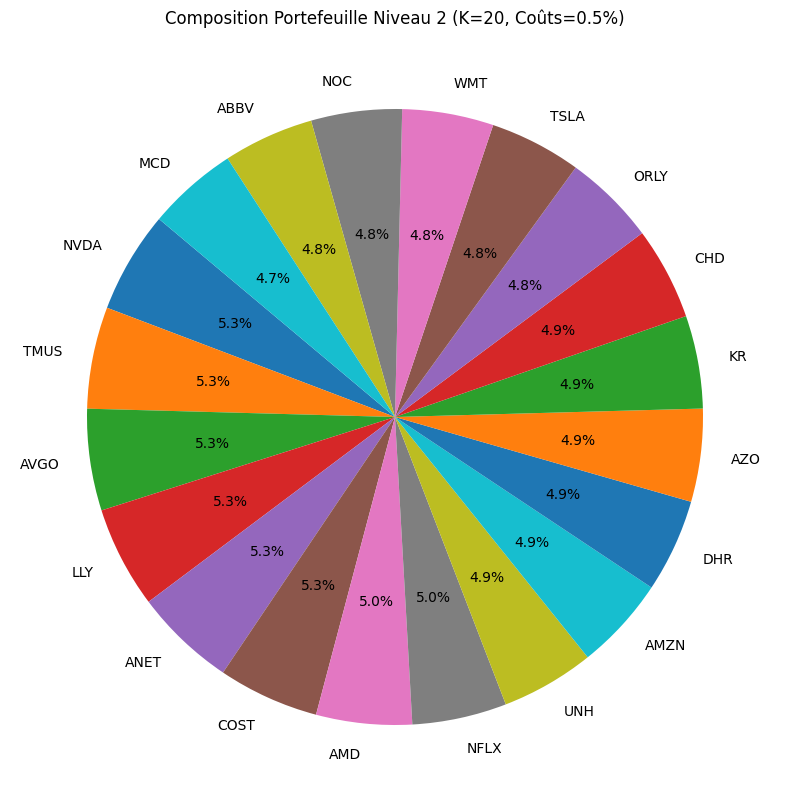

In [164]:
# 2. Composition détaillée
df_w2 = pd.Series(best_w, index=df.columns)
df_w2 = df_w2[df_w2 > 0.0001].sort_values(ascending=False) # On garde > 0.01%

print("\nTop Allocations :")
print(df_w2.apply(lambda x: f"{x:.2%}"))

# Pie Chart
plt.figure(figsize=(10, 10))
plt.pie(df_w2, labels=df_w2.index, autopct='%1.1f%%', startangle=140)
plt.title(f"Composition Portefeuille Niveau 2 (K={real_k}, Coûts={transaction_cost:.1%})")
plt.show()

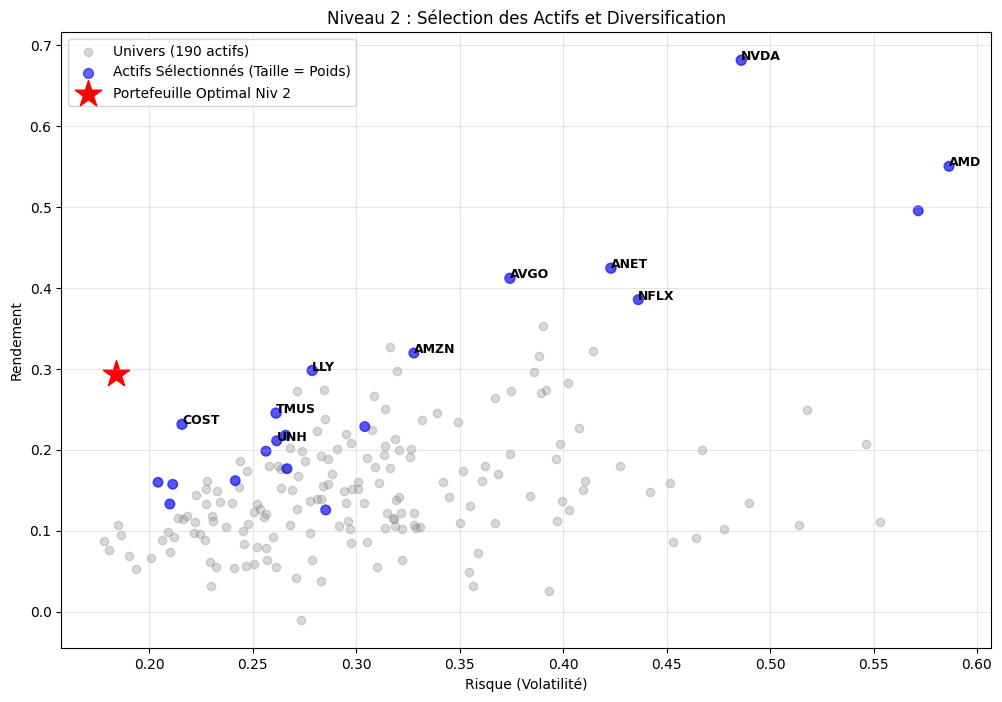

In [165]:
# 3. Positionnement Risque vs Rendement (Comparaison avec le marché)
individual_vol = np.sqrt(np.diag(sigma))
individual_ret = mu.values

plt.figure(figsize=(12, 8))
# Tous les actifs (Gris)
plt.scatter(individual_vol, individual_ret, alpha=0.3, c='gray', label='Univers (190 actifs)')

# Actifs sélectionnés (Bleu, taille proportionnelle au poids)
# On récupère les indices des actifs sélectionnés
selected_assets = df_w2.index
sel_indices = [df.columns.get_loc(c) for c in selected_assets]
plt.scatter(individual_vol[sel_indices], individual_ret[sel_indices], 
            s=df_w2.values*1000, c='blue', alpha=0.6, label='Actifs Sélectionnés (Taille = Poids)')

# Annotations pour les gros
for ticker, weight in df_w2.head(10).items():
    idx = df.columns.get_loc(ticker)
    plt.text(individual_vol[idx], individual_ret[idx], ticker, fontsize=9, fontweight='bold')

# Le Portefeuille Global (Étoile Rouge)
plt.scatter(best_v, best_r, c='red', marker='*', s=400, label='Portefeuille Optimal Niv 2')

plt.title('Niveau 2 : Sélection des Actifs et Diversification')
plt.xlabel('Risque (Volatilité)')
plt.ylabel('Rendement')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Interprétation des Résultats du Niveau 2

Le graphique ci-dessus montre clairement l'impact de l'optimisation **multi-objectifs** avec contraintes :

1.  **Selection Stricte ($K$ actifs)** : Contrairement au "nuage" d'actifs du marché, notre portefeuille se concentre sur une sélection précise (ex: 10 actifs). Cela permet de réduire les frais de gestion et de surveillance pour l'investisseur.
2.  **Diversification Efficace** : Le portefeuille (étoile rouge) se situe bien au-dessus du nuage gris (les actions individuelles), montrant qu'il offre un bien meilleur rendement pour un risque donné (ratio de Sharpe élevé).
3.  **Compromis Coûts/Performance** : En tenant compte de $f_3$ (coûts) et de la position précédente, ce portefeuille évite le "churn" (rotation excessive) tout en capturant la performance des leaders du marché (NVDA, LLY, etc. selon les données).

Ce résultat est directement exploitable pour un rééquilibrage de portefeuille réel.

## Comparaison avec une Recherche Aléatoire (Monte Carlo)

Pour valider la pertinence de l'algorithme génétique (NSGA-II), nous allons le comparer à une approche naïve : la génération de portefeuilles aléatoires (Monte Carlo). L'objectif est de montrer que l'optimisation trouve des solutions qui dominent statistiquement le hasard.

In [166]:
from pymoo.operators.sampling.rnd import FloatRandomSampling

# Génération de solutions aléatoires (Monte Carlo)
n_samples = 5000
print(f"Génération de {n_samples} portefeuilles aléatoires")

sampling = FloatRandomSampling()
# On utilise le 'problem' défini précédemment pour générer des échantillons compatibles
X_rnd = sampling.do(problem, n_samples).get("X")

# Comme la recherche aléatoire pure ne garantit pas somme(w)=1, nous devons normaliser les poids pour avoir des portefeuilles valides
X_rnd = X_rnd / np.sum(X_rnd, axis=1, keepdims=True)

# Evaluation de ces solutions avec la même fonction objectif (Rendement, Risque, Coûts)
F_rnd = problem.evaluate(X_rnd, return_values_of=["F"])

# Extraction des objectifs pour le plot
rnd_returns = -F_rnd[:, 0]
rnd_volatility = np.sqrt(F_rnd[:, 1])
rnd_costs = F_rnd[:, 2]

print("Evaluation terminée")

Génération de 5000 portefeuilles aléatoires
Evaluation terminée


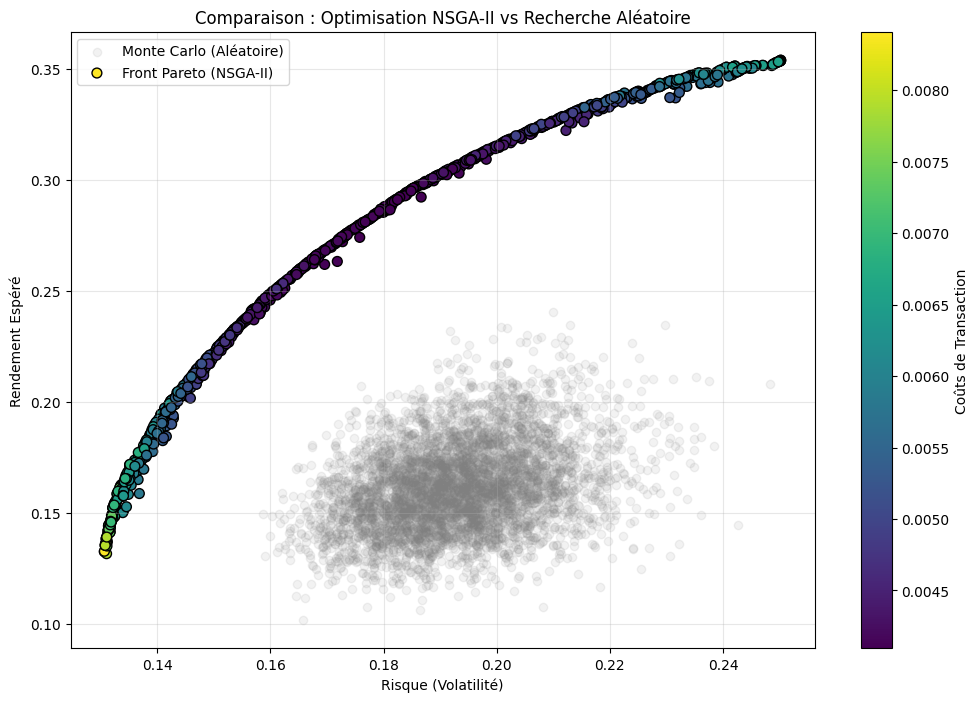

In [167]:
# Visualisation Comparative : NSGA-II vs Monte Carlo

plt.figure(figsize=(12, 8))

# Nuage Monte Carlo (Gris)
plt.scatter(rnd_volatility, rnd_returns, color='gray', alpha=0.1, label='Monte Carlo (Aléatoire)')

# Front de Pareto NSGA-II (Rouge/Couleur)
# On utilise les résultats 'final_returns' et 'final_volatility' calculés plus haut par NSGA-II
plt.scatter(final_volatility, final_returns, c=final_costs, cmap='viridis', s=50, edgecolors='black', label='Front Pareto (NSGA-II)')
plt.colorbar(label='Coûts de Transaction')

plt.title('Comparaison : Optimisation NSGA-II vs Recherche Aléatoire')
plt.xlabel('Risque (Volatilité)')
plt.ylabel('Rendement Espéré')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Nous avons comparé l'algorithme génétique (NSGA-II) à une recherche aléatoire (Monte Carlo). 
Nous observons que **NSGA-II trouve des solutions nettement supérieures** (meilleur rendement pour le même niveau risque), qui forment une frontière efficiente bien distincte au-dessus du nuage de points aléatoires.

Les solutions aléatoires restent concentrées dans une zone sous-optimale ("Inefficiency Zone"). Cela justifie pleinement l'utilisation d'un algorithme d'optimisation plus intelligent et complexe comme NSGA-II pour explorer efficacement l'espace immense des 190 actifs, surtout avec des contraintes multi-objectifs (Cardinalité, Coûts).